C:\Users\ClementXu\anaconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ClementXu\anaconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\ClementXu\AppData\Local\Temp\ipykernel_22636\2575351373.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default valu

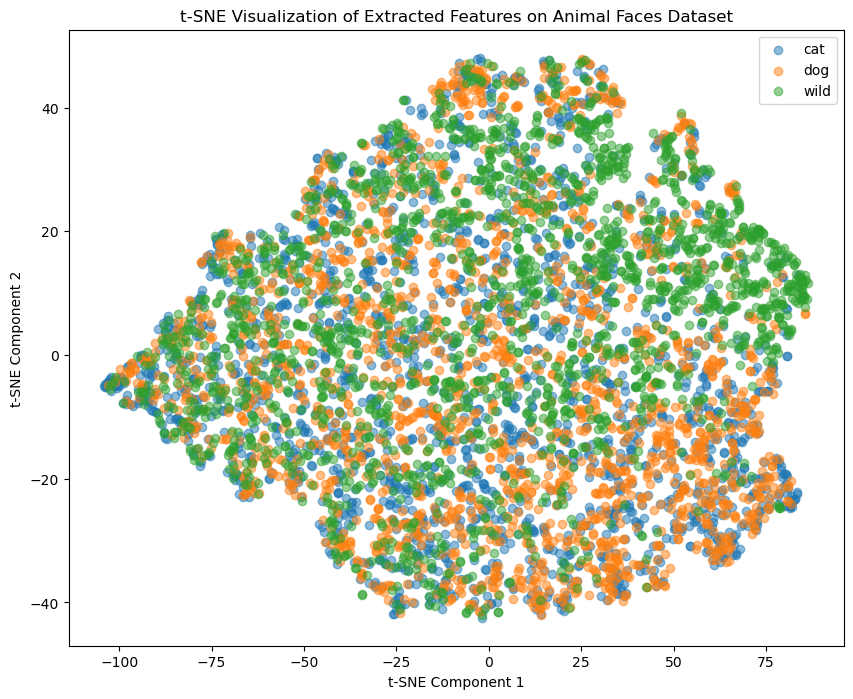

In [1]:
import torch
from torchvision import datasets, transforms,models
from torch.utils.data import DataLoader
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

class CustomResNet18(torch.nn.Module):
    def __init__(self, num_classes=3):
        super(CustomResNet18, self).__init__()
        resnet = models.resnet18(pretrained=False) 
        self.features = torch.nn.Sequential(*list(resnet.children())[:-1])  

    def forward(self, x):
        x = self.features(x)  
        x = x.view(x.size(0), -1)  
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomResNet18(num_classes=3).to(device)
model.load_state_dict(torch.load('final_feature_resnet18.pth'),strict=False) 
model.eval()  


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


dataset3_path = './Dataset3/AnimalFaces'
dataset3 = datasets.ImageFolder(root=dataset3_path, transform=transform)
data_loader3 = DataLoader(dataset3, batch_size=32, shuffle=False, num_workers=4)

def extract_features(data_loader, model):
    model.eval()  
    features, labels = [], []
    with torch.no_grad():
        for images, label in data_loader:
            images = images.to(device)  
            output = model(images) 
            features.append(output.cpu().numpy())  
            labels.append(label.numpy())  
    features = np.concatenate(features)  
    labels = np.concatenate(labels)  
    return features, labels

features3, labels3 = extract_features(data_loader3, model)

tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(features3)


plt.figure(figsize=(10, 8))
for label in np.unique(labels3):
    idx = labels3 == label
    plt.scatter(reduced_features[idx, 0], reduced_features[idx, 1], label=dataset3.classes[label], alpha=0.5)
plt.legend()
plt.title("t-SNE Visualization of Extracted Features on Animal Faces Dataset")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
# Classification: RF

X_train, X_test, y_train, y_test = train_test_split(features3, labels3, test_size=0.2, random_state=42)

classifier = RandomForestClassifier(n_estimators=100, random_state=42)

classifier.fit(X_train, y_train) 

# predict and calculate the accuracy
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Accuracy on Dataset 2: {accuracy * 100:.2f}%")

Classification Accuracy on Dataset 2: 63.83%


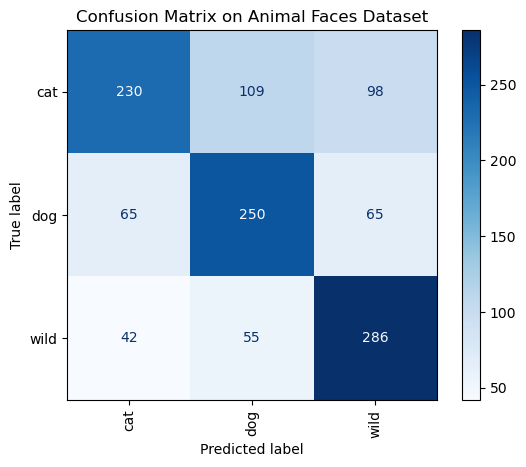

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset3.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix on Animal Faces Dataset")
plt.show()

In [5]:
# Generate classification report
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=dataset3.classes))

Classification Report:
              precision    recall  f1-score   support

         cat       0.68      0.53      0.59       437
         dog       0.60      0.66      0.63       380
        wild       0.64      0.75      0.69       383

    accuracy                           0.64      1200
   macro avg       0.64      0.64      0.64      1200
weighted avg       0.64      0.64      0.64      1200

